In [1]:
import numpy as np
import pickle
import copy
import math
import matplotlib.pyplot as plt

In [3]:
data = []
labels = []
#loading pickle files
for i in range(1,7):
    with open(f'../data/cifar-10-batches/data_batch_{i}','rb') as f:
        dict_one = pickle.load(f)
        data.append(dict_one[b'data'])
        labels.append(dict_one[b'labels'])
        f.close()

In [4]:
with open('../data/cifar-10-batches/batches.meta','rb') as f:
    label_values = pickle.load(f)
    f.close()

In [5]:
data = np.concatenate(data,axis=0)
labels = np.concatenate(labels,axis=0)
data = np.true_divide(data,255)

In [6]:
test_data = data[50000:]
test_labels = labels[50000:]
data = data[:50000]
labels = labels[:50000]

In [7]:
input_layer = np.empty([1024,1],dtype=float)
hidden_layers =[np.empty([1024,1],dtype=float),np.empty([512,1],dtype=float),np.empty([128,1],dtype=float)]
output_layer = np.empty([10,1],dtype=float)

In [8]:
layers=[input_layer,*hidden_layers,output_layer]

In [9]:
def create_weights(l):
    E = 0.5
    thetas = []
    wb = []
    dwb = []
    dthetas = []
    for i in range(1,len(layers)):
        thetas.append(((np.random.rand(len(layers[i]),len(layers[i-1]))*(2*E))-E)*math.sqrt(2/len(layers[i-1])))
        wb.append(((np.random.rand(len(layers[i]),1)*(2*E))-E)*math.sqrt(2/len(layers[i-1]))/10)
        dthetas.append(np.zeros(thetas[-1].shape,dtype=float))
        dwb.append(np.zeros(wb[-1].shape,dtype=float))
    return thetas,wb,dthetas,dwb

In [10]:
def sigmoid(z):
    return 1/(1+np.exp(z*(-1)))

In [11]:
def ReLu(z):
    return np.maximum(0,z)

In [12]:
pd = np.vectorize(lambda a: 1 if a>0 else 0)

In [12]:
thetas,wb,dthetas,dwb = create_weights(layers)

In [13]:
[thetas,wb] = pickle.load(open('weights','rb')) 

In [79]:
costs = []
delta = copy.deepcopy(layers)

In [80]:
cost = 0
alpha = 0.1
batch_size = 100

In [81]:
for _ in range(16):#epochs
    for d in range(len(data)):
        layers[0] = np.reshape(data[d],[1024,1])
        #forward propogation
        for i in range(len(layers)-2):
            layers[i+1] = ReLu(np.dot(thetas[i],layers[i])+wb[i])
        layers[-1] = sigmoid(np.dot(thetas[-1],layers[-2])+wb[-1])
        y = np.zeros([10,1],dtype=int)
        y[labels[d],0] = 1
        cost+=np.sum(-1*((y)*np.log(layers[-1])+(1-y)*np.log(1-layers[-1])))
        #backpropogation
        delta[-1] = layers[-1] - y
        #calculating partial derivative with respect to theta
        for i in range(len(layers)-2,0,-1):
            delta[i] = np.dot(np.transpose(thetas[i]),delta[i+1])*pd(layers[i])
            dthetas[i] += np.dot(delta[i+1],np.transpose(layers[i]))
            dwb[i] += delta[i+1]
        dthetas[0] += np.dot(delta[1],np.transpose(layers[0]))
        dwb[0] += delta[1]
        #training on mini batch sizes of 100
        if((d+1)%batch_size!=0):
            continue
        costs.append(cost/batch_size)
        cost = 0
        #updating weights
        for i in range(len(dthetas)):
            dthetas[i]/=batch_size
            dwb[i]/=batch_size
            #gradient descent
            thetas[i] -= alpha*dthetas[i]
            wb[i]-=alpha*dwb[i]
            #resetting to zero
            dthetas[i] = np.zeros(thetas[i].shape,dtype=float)
            dwb[i] = np.zeros(wb[i].shape,dtype=float)

<ipython-input-81-586ede67785b>:10: RuntimeWarning: divide by zero encountered in log
  cost+=np.sum(-1*((y)*np.log(layers[-1])+(1-y)*np.log(1-layers[-1])))
<ipython-input-81-586ede67785b>:10: RuntimeWarning: invalid value encountered in multiply
  cost+=np.sum(-1*((y)*np.log(layers[-1])+(1-y)*np.log(1-layers[-1])))


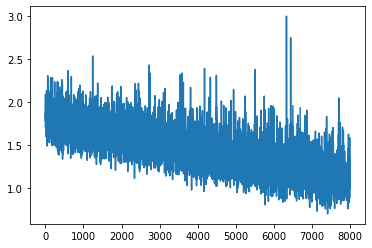

In [82]:
plt.plot(costs)
plt.show()

In [83]:
costs[-1]

0.9947885854752944

## Testing

In [25]:
correct = 0
for d in range(len(test_data)):
    layers[0] = np.reshape(test_data[d],[1024,1])
    #forward propogation
    for i in range(len(layers)-2):
        layers[i+1] = ReLu(np.dot(thetas[i],layers[i])+wb[i])
    layers[-1] = sigmoid(np.dot(thetas[-1],layers[-2])+wb[-1])
#     print(np.round(layers[-1],decimals=2))
#     print(labels[d])
    if layers[-1].argmax() == test_labels[d]:
        correct += 1

In [26]:
print((correct/len(test_data))*100)

43.05


## Saving Weights

In [86]:
pickle.dump([thetas,wb],open("weights",'wb'))